###  Zhao, Morrison, Parr Inversion Method:

In [1]:
import os
import psi4
import matplotlib.pyplot as plt
import numpy as np
# import numpy_html
psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 


  Memory set to   2.328 GiB by Python driver.


In [2]:
#Define Psi4 geometries. Symmetries need to be set to C1. 


Ne = psi4.geometry( 
""" 
0 1
Ne 0.0 0.0 0.0
noreorient
nocom
units bohr
symmetry c1
""" )

#n2v is driven by psi4's reference option. Make sure you set it accordingly. 
psi4.set_options({"reference" : "rhf"})

#Perform a calculation for a target density. 
#Remember that for post scf calculations, Psi4 does not update the density. 
#Thus make sure you obtain something like a dipole in order to do so. 
e, wfn = psi4.properties("CCSD/aug-cc-pvtz", return_wfn=True, properties=["dipole"], molecule=Ne)

In [3]:
#Define inverter objects for each molcule. Simply use the wnf object from psi4 as an argument. 
inv = n2v.Inverter('psi4')
inv.set_system(Ne, 'aug-cc-pvtz', wfn=wfn)
inv.Dt = [ np.array(wfn.Da()), np.array(wfn.Db()) ]
inv.ct = [ np.array(wfn.Ca_subset("AO", "OCC")), np.array(wfn.Cb_subset("AO", "OCC")) ]
inv.et = [ np.array(wfn.epsilon_a_subset("AO", "OCC")), np.array(wfn.epsilon_b_subset("AO", "OCC"))]

# Additionally one can simply initialize an Inverter using the wavefunction. 
inv = n2v.Inverter.from_wfn(wfn)

 Let us now invert the density using the [Zhao, Morrison, Parr Method](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.50.2138):

---
##### The Zhao, Morrison, Parr method works by updating self-consistently a potential generated by the difference in density. 
The driving potential at step $i$ is:

$$v_c^i(r) = \lambda \int \frac{n_i(r') - n_{0}(r')}{|r-r'|} dr'$$

where $n(r)$ is the current density iteration and $n_0(r)$ is the target density that remains fixed during the scf procedure.

The $\lambda$ parameter is a Lagrange multiplier that in the limit of $\lambda \rightarrow \infty$, allows $v_c$ to become the exact potential. In practice we won't be able to increase lambda arbitrarily but values like $25$, $50$ or $75$ are commonly used. An iterative approach also lets you perform an extrapolation technique iteratively. In order to trigger this calculation, specify more than one lambda. A reliable option to choose is to begin with $\lambda=10$ and make enough iterations to achieve desired convergence in density. 

The algorithm will need an initial potential components to guide the inversion procedure. It is common to use the "Fermi Amaldi" (FA) Potential. Let us now use all of the previous information to perform the desired inversions. 

---
##### The potential that we are looking for is driven by density difference. The potential is then added to the Fock matrix as Hartree contribution. 
##### Thus if we want to visualize the potential, we need to compute the Hartree of a combination of the obtained density and the target density according to:

$$
v_{xc}(r) = v_c(r) - (1-1/N) \cdot v_{FA}(r)
$$

In practice, the result from the scf calculation is stored in:
```
inverter.proto_density_a
inverter.proto_density_b
```
We need to provide this information to the Hartree generating function. This function uses the density stored in the initial wfn object. Thus we need to overwrite this quantity. (Be careful, this is a destructive action that will permanently remove the density within the wfn object).

##### Finally we plot as if we were trying to extract the Hartree potential according $v_c(r)$ above.

In [4]:
# Let us define a plotting grid:

npoints=1001
x = np.linspace(-5,5,npoints)[:,None]
y = np.zeros_like(x)
z = y
grid = np.concatenate((x,y,z), axis=1).T

Let's do ZMP calculation. Let's first try **zmp_mixing=1**, which means that all the potentials of previous lambdas are accumulated, the larger lambda potential are meant to fix the wrong/inaccurate region of the potential of the sum of the previous potentials instead of providing an entire new potentials:
$$v_c^i(r) = v_c^{i-1}(r) + \Delta v_i = \sum_{j\leq i} \lambda_j \int \frac{n_j(r') - n_{0}(r')}{|r-r'|} dr'.$$

In [5]:
inv.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=1, 
           lambda_list=np.linspace(10, 1000, 20), guide_components="fermi_amaldi")


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 15.831574866706546
SCF Converged for lambda:   62. Max density difference: 3.3219948668290726
SCF Converged for lambda:  114. Max density difference: 0.2761439094172147
SCF Converged for lambda:  166. Max density difference: 0.15320869221534394

ZMP halted at lambda=218.42105263157896. Density Error Stops Updating: old: 0.15320869221534394, current: 0.18483774583955892.


In [6]:
inv.eigvecs_a[:inv.nalpha]

array([-30.96371088,  -1.64633607,  -0.78780287,  -0.78780287,
        -0.78780287])

In [7]:
np.diag(inv.Da)[:inv.nalpha]

array([0.9520639 , 0.33023202, 0.03466103, 0.13804668, 0.16689393])

(-5.0, 5.0)

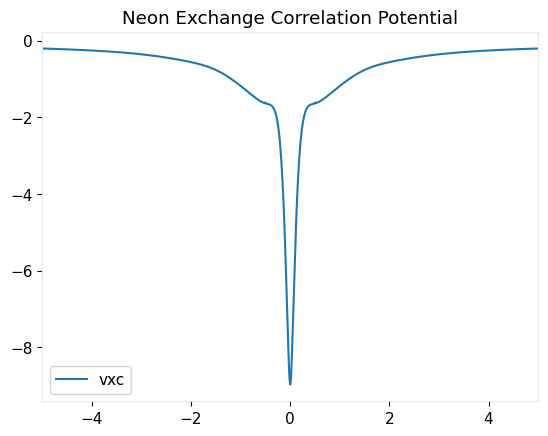

In [8]:
results = inv.eng.grid.esp(Da=inv.proto_density_a, Db=inv.proto_density_b, grid=grid, )
vxc_ne = results[1]

fig, ax = plt.subplots()
ax.plot(x,  vxc_ne, label="vxc")
ax.set_title("Neon Exchange Correlation Potential")

ax.legend()
ax.set_xlim(-5,5)

Let's modify the **zmp_mixing=0.5**: $$v_c^i(r) = \text{zmp}_\text{mixing} \times v_c^{i-1}(r) + \Delta v_i.$$

In [9]:
inv.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=0.5, 
           lambda_list=np.linspace(10, 1000, 20), guide_components="fermi_amaldi")


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 15.831574866706546
SCF Converged for lambda:   62. Max density difference: 4.331349801754186
SCF Converged for lambda:  114. Max density difference: 1.4784330075436856
SCF Converged for lambda:  166. Max density difference: 0.4836375491295257
SCF Converged for lambda:  218. Max density difference: 0.0967523728593278
SCF Converged for lambda:  270. Max density difference: 0.0590538146052495

ZMP halted at lambda=322.63157894736844. Density Error Stops Updating: old: 0.0590538146052495, current: 0.12012063696420228.


(-5.0, 5.0)

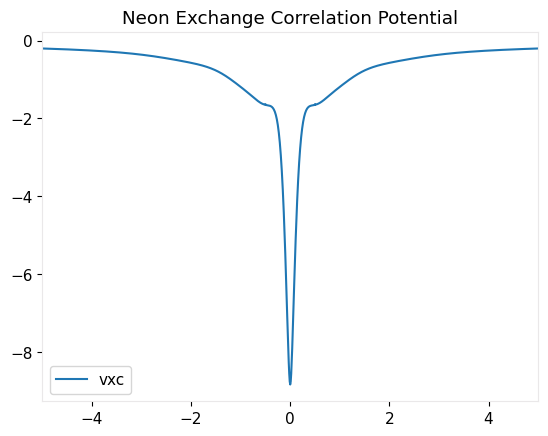

In [10]:
results = inv.eng.grid.esp(Da=inv.proto_density_a, Db=inv.proto_density_b, grid=grid, )
vxc_ne1 = results[1]

fig, ax = plt.subplots()
ax.plot(x,  vxc_ne1, label="vxc")
ax.set_title("Neon Exchange Correlation Potential")

ax.legend()
ax.set_xlim(-5,5)

Or **zmp_mixing=0**, which make only the last lambda will contribute to the resulting potential at each scf step.

In [11]:
inv.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=0, 
           lambda_list=np.linspace(10, 1000, 20), guide_components="fermi_amaldi")


Running ZMP:


SCF Converged for lambda:   10. Max density difference: 15.831574866706546
SCF Converged for lambda:   62. Max density difference: 5.340333527727921
SCF Converged for lambda:  114. Max density difference: 3.1553683805267383
SCF Converged for lambda:  166. Max density difference: 2.206797660278994
SCF Converged for lambda:  218. Max density difference: 1.6772710831739914
SCF Converged for lambda:  270. Max density difference: 1.3399195637271077
SCF Converged for lambda:  322. Max density difference: 1.106600598555815
SCF Converged for lambda:  374. Max density difference: 0.9359062551369561
SCF Converged for lambda:  426. Max density difference: 0.8058110669946927
SCF Converged for lambda:  478. Max density difference: 0.7035194254741555
SCF Converged for lambda:  531. Max density difference: 0.6210900910868986
SCF Converged for lambda:  583. Max density difference: 0.5533348009839756
SCF Converged for lambda:  635. Max density difference: 0.4967201553572522
SCF Converged for lambda:  

(-5.0, 5.0)

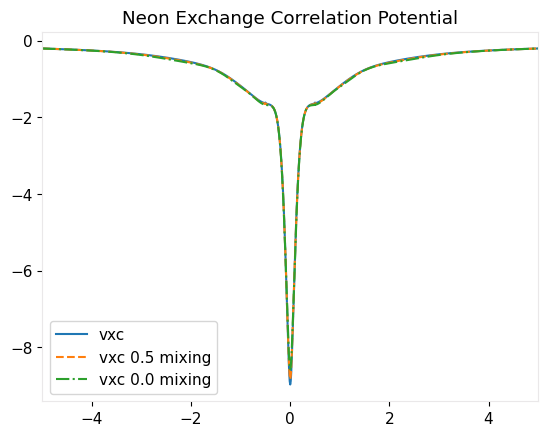

In [12]:
results = inv.eng.grid.esp(Da=inv.proto_density_a, Db=inv.proto_density_b, grid=grid, )
vxc_ne2 = results[1]

plt.plot(x,  vxc_ne, label="vxc")
plt.plot(x,  vxc_ne1, label="vxc 0.5 mixing", ls="--")
plt.plot(x,  vxc_ne2, label="vxc 0.0 mixing", ls="-.")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
plt.xlim(-5,5)
# plt.ylim(-10,1)

In [13]:
inv.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=0.1, 
           lambda_list=np.linspace(10, 1000, 20), guide_components="fermi_amaldi")


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 15.831574866706546
SCF Converged for lambda:   62. Max density difference: 5.138566656582498
SCF Converged for lambda:  114. Max density difference: 2.782053106629405
SCF Converged for lambda:  166. Max density difference: 1.754126037748847
SCF Converged for lambda:  218. Max density difference: 1.187279952487529
SCF Converged for lambda:  270. Max density difference: 0.8344483706051733
SCF Converged for lambda:  322. Max density difference: 0.5980863516479076
SCF Converged for lambda:  374. Max density difference: 0.43184234199190996
SCF Converged for lambda:  426. Max density difference: 0.310852233846731
SCF Converged for lambda:  478. Max density difference: 0.2205836730674946
SCF Converged for lambda:  531. Max density difference: 0.15198081394271412
SCF Converged for lambda:  583. Max density difference: 0.09911515803833026
SCF Converged for lambda:  635. Max density difference: 0.06136167898733902
SCF Converge

In [14]:
results = inv.eng.grid.esp(Da=inv.proto_density_a, Db=inv.proto_density_b, grid=grid, )
vxc_ne3 = results[1]

(-5.0, 5.0)

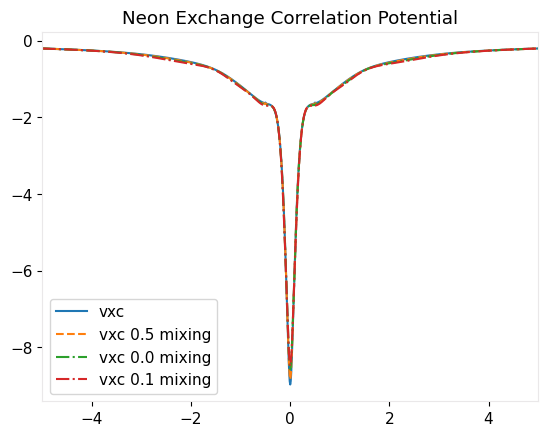

In [15]:
plt.plot(x,  vxc_ne, label="vxc")
plt.plot(x,  vxc_ne1, label="vxc 0.5 mixing", ls="--")
plt.plot(x,  vxc_ne2, label="vxc 0.0 mixing", ls="-.")
plt.plot(x,  vxc_ne3, label="vxc 0.1 mixing", ls="-.")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
plt.xlim(-5,5)


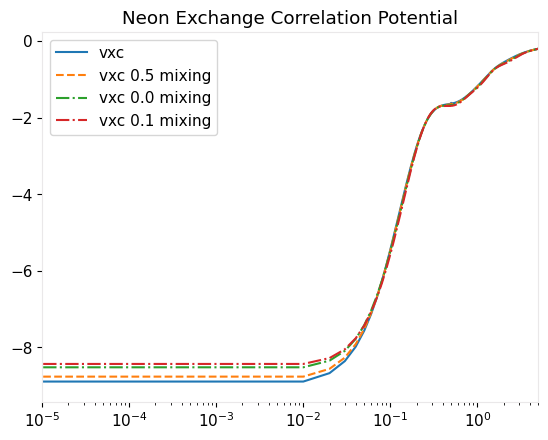

In [16]:
fig, ax = plt.subplots()
ax.plot(x,  vxc_ne, label="vxc")
ax.plot(x,  vxc_ne1, label="vxc 0.5 mixing", ls="--")
ax.plot(x,  vxc_ne2, label="vxc 0.0 mixing", ls="-.")
ax.plot(x,  vxc_ne3, label="vxc 0.1 mixing", ls="-.")
ax.set_title("Neon Exchange Correlation Potential")

ax.legend()
ax.set_xlim(1e-5,5)
ax.set_xscale("log")